# BM4D Experiment

In [1]:
import os
import json
import time

import bm4d
import numpy as np
import matplotlib.pyplot as plt

from module.utils import calculate_metrics, display_image_in_detail, plot_2d_data, timer_decorator, display_4d_image
from module.datasets import load_4d_dicom, save_4d_dicom, restore_data

import h5py

from tqdm.notebook import tqdm

In [2]:
from scipy.stats import median_abs_deviation

def mad_estimate(image):
    median = np.median(image)

    # calculate the diff between all pixels and median 
    mad = median_abs_deviation(image)

    # convert MAD into std estimation
    # 0.6745 is constant number for gaussian distribution
    noise_level = mad / 0.6745

    return np.mean(noise_level)



from scipy.ndimage import uniform_filter
# define Anscombe transform
def anscombe(x):
    return 2 * np.sqrt(x + 3 / 8)

# define inverse anscombe transform
def inv_anscombe(y):
    return (y / 2) ** 2 - 3 / 8

# estimate transformed noise std by sliding window
def anscombe_estimate(image, window_size=7):
    # calculate local mean
    local_mean = uniform_filter(image, window_size)
    
    # calculate local variance
    local_var = uniform_filter(image**2, window_size) - local_mean**2
    
    # calcualte average std 
    noise_std = np.sqrt(np.clip(local_var, 0, np.inf)).mean()
    
    return noise_std

## Load dataset

In [3]:
# load noisy data
with h5py.File('./dataset/preprocessed/PT_20p 150_120 OSEM_poisson_0.10_batch.h5', 'r') as f:
    noisy_data = f['dataset'][...]
    restore_info = json.loads(f['restore_info'][()])
    
print(f"Noisy data...{noisy_data.dtype} (shape:{noisy_data.shape}; range:[{np.min(noisy_data)},{np.max(noisy_data)}]; mean:{np.mean(noisy_data)}); std:{np.std(noisy_data)}")

print(restore_info)


Noisy data...float32 (shape:(11, 24, 71, 192, 192); range:[0.0,1.0]; mean:0.47556254267692566); std:0.021635757759213448
{'original_min': -32768.0, 'original_max': 32767.0, 'z_score_mean': 201.4710693359375, 'z_score_std_dev': 1407.2664794921875, 'noise_min': -23.428024291992188, 'noise_max': 26.14098358154297}


## Example denoising 

noisy_image: dtype:float32 range(0.39052823185920715,0.9664080739021301) mean:0.47526782751083374 std:0.020861972123384476
estimate noise_level: 0.010733912698924541
denoised_image: dtype:float64 range(0.3919735550880432,0.9567834138870239) mean:0.4749214573863307 std:0.019295007545090143
calculate_metrics running: 2.488641055300832 second
PSNR: 37.46972892156155; SSIM: 0.8442671805619525; MAE: 0.34945377742244293; BRISQUE: 113.43287738341684


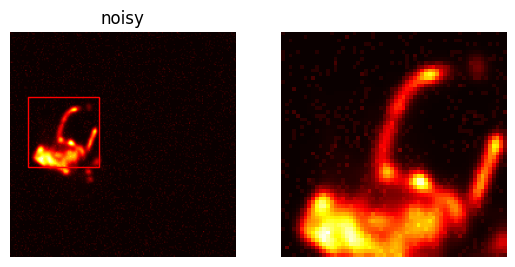

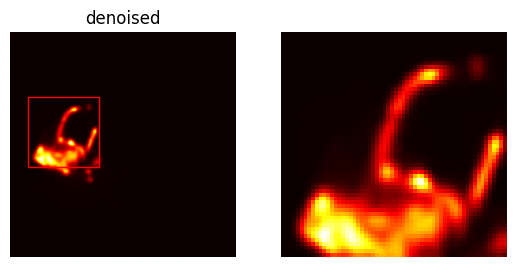

In [4]:
#
noisy_image = noisy_data[0, 11]
print(f"noisy_image: dtype:{noisy_image.dtype} range({np.min(noisy_image)},{np.max(noisy_image)}) mean:{np.mean(noisy_image)} std:{np.std(noisy_image)}")


# estimate noise level 
# noise_level = 0
# noise_level = mad_estimate(noisy_image)
noise_level = anscombe_estimate(anscombe(noisy_image))

print(f"estimate noise_level: {noise_level}")


# process denoising using MAD for estimate since it better
denoised_image = bm4d.bm4d(noisy_image, noise_level)
print(f"denoised_image: dtype:{denoised_image.dtype} range({np.min(denoised_image)},{np.max(denoised_image)}) mean:{np.mean(denoised_image)} std:{np.std(denoised_image)}")


# calculate PSNR, SSIM and MAE
data_range_denoised = np.max(denoised_image) - np.min(denoised_image)
data_range_noisy = np.max(noisy_image) - np.min(noisy_image)
data_range = max(data_range_denoised, data_range_noisy)
psnr_values, ssim_values, mae_values, brisque_values = calculate_metrics(denoised_image, noisy_image, data_range=data_range)
print(f"PSNR: {np.nanmean(psnr_values)}; SSIM: {np.nanmean(ssim_values)}; MAE: {np.sum(mae_values)}; BRISQUE: {np.mean(brisque_values)}")


# show result
time_idx = 11
depth_idx = 38
zoom_coordinates = (55, 15, 60, 60)
display_image_in_detail(noisy_image[depth_idx], title='noisy')
display_image_in_detail(denoised_image[depth_idx], title='denoised')

## Process denoising

In [5]:
# denoised 
@timer_decorator
def process(noisy_data, noise_level):
    denoised_data = np.zeros_like(noisy_data)
    with tqdm(total=noisy_data.shape[0]) as pbar:
        for i in range(noisy_data.shape[0]):
            sub_image = noisy_data[i, :, :, :]
            #noise_level = 0
            #noise_level = mad_estimate(sub_image)
            noise_level = anscombe_estimate(anscombe(sub_image))
            
            denoised_sub_image = bm4d.bm4d(sub_image, noise_level)
            denoised_data[i, :, :, :] = denoised_sub_image
            pbar.update(1)
    return denoised_data



# noise_level = anscombe_estimate(anscombe(noisy_data[0]))
# noise_level = mad_estimate(noisy_data[0])
# print(f"estimate noise_level: {noise_level}")

denoised_data = process(noisy_data[0], noise_level)
            
print(f"denoised_data: dtype:{denoised_data.dtype} range({np.min(denoised_data)},{np.max(denoised_data)}) mean:{np.mean(denoised_data)} std:{np.std(denoised_data)}")

  0%|          | 0/24 [00:00<?, ?it/s]

process running: 4367.116792371497 second
denoised_data: dtype:float32 range(-0.0027618694584816694,0.9802266359329224) mean:0.4753296673297882 std:0.02011474221944809


## Evaluation

Calculate PSNR, SSIM, MAE, BRISQUE

data range: 0.9999856352806091
calculate_metrics running: 46.999189376831055 second
PSNR: 42.20483146686125; SSIM: 0.9396643701132015; MAE: 8.53182523837313; BRISQUE: 110.53490493224594


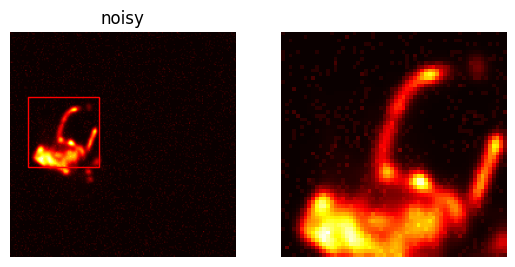

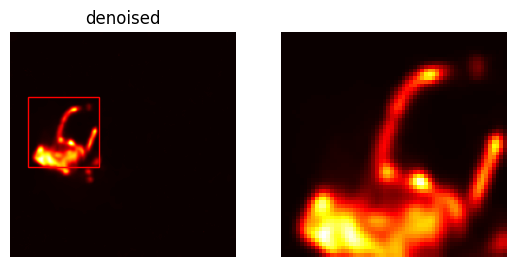

In [6]:
# calcualte PSNR, SSIM between denoised data and noisy data
data_range_noisy = np.max(noisy_data[0]) - np.min(noisy_data[0])
data_range_denoised = np.max(denoised_data) - np.min(denoised_data)
data_range = max(data_range_noisy, data_range_denoised)
print(f"data range: {data_range}")

#
psnr_values, ssim_values, mae_values, brisque_values = calculate_metrics(denoised_data, noisy_data[0], data_range=data_range)
print(f"PSNR: {np.nanmean(psnr_values)}; SSIM: {np.nanmean(ssim_values)}; MAE: {np.sum(mae_values)}; BRISQUE: {np.mean(brisque_values)}")

display_image_in_detail(noisy_data[0, 11, 38], title="noisy")
display_image_in_detail(denoised_data[11, 38], title="denoised")

## Save denormalized denoised image into int16 DICOM file

In [7]:
# # denormalzied denoised data
# mean_val = 201.12048776036573
# std_val = 1412.4139804758772
# max_val = 23.05689405684542
# min_val = -23.34168377224119


# denormalized_denoised_data = denoised_data * (max_val - min_val) + min_val
# denormalized_denoised_data = denormalized_denoised_data * std_val + mean_val

# denormalized_denoised_data = np.clip(denormalized_denoised_data, np.iinfo(np.int16).min, np.iinfo(np.int16).max).astype(np.int16)


# print(f"denormalized_denoised_data: dtype:{denormalized_denoised_data.dtype} range({np.min(denormalized_denoised_data)},{np.max(denormalized_denoised_data)}) mean:{np.mean(denormalized_denoised_data)} std:{np.std(denormalized_denoised_data)}")

# display_4d_image(denormalized_denoised_data)

In [8]:
restored_data = restore_data(denoised_data, restore_info)
print(f"restore_data: {restored_data.dtype} shape:{restored_data.shape}; range:({np.min(restored_data)},{np.max(restored_data)}); mean:{np.mean(restored_data)}; std:{np.std(restored_data)}")
display_4d_image(restored_data)

restore_data: int16 shape:(24, 71, 192, 192); range:(-32768,32767); mean:389.3337263048597; std:1403.0110015614675


interactive(children=(IntSlider(value=0, description='Time', max=23), IntSlider(value=0, description='Slice', …

In [9]:
origin_dicom_folder = './dataset/10_05_2021_PET_only/PT_20p 150_120 OSEM'

output_folder = './dataset/denoised/BM4D/PT_20p 150_120 OSEM_poisson_0.10_batch'

save_4d_dicom(origin_dicom_folder, restored_data, output_folder)

Processing time points: 100%|██████████| 24/24 [00:15<00:00,  1.53it/s]

Saved 1704 denoised DICOM files.
